In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch.4 RNN 순환신경망</font><b>
- Sequential Model. 데이터의 순서가 중요하거나(자언어, 음악 등), 시계열 데이터일 경우
- 활용 분야: 번역, 음성인식, 주가예측, 농수산물가격예측
# 1. 문맥을 이용하여 모델 만들기

In [2]:
text = """경마장에 있는 말이 뛰고 있다.
그의 말이 곧 법이다.
가는 말이 고와야 오는 말이 곱다"""
text1 = "곧 겨울이 오는 날"

In [3]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text, text1])
encoded = t.texts_to_sequences([text, text1])
print(encoded)
print(t.word_index)

[[4, 5, 1, 6, 7, 8, 1, 2, 9, 10, 1, 11, 3, 1, 12], [2, 13, 3, 14]]
{'말이': 1, '곧': 2, '오는': 3, '경마장에': 4, '있는': 5, '뛰고': 6, '있다': 7, '그의': 8, '법이다': 9, '가는': 10, '고와야': 11, '곱다': 12, '겨울이': 13, '날': 14}


In [4]:
t.texts_to_sequences(['경마장에 있는 말이 달린다']) #반드시 리스트로 입력 # 인코딩 안 된 텍스트('달린다')는 해석되지 않음

[[4, 5, 1]]

In [5]:
text = """경마장에 있는 말이 뛰고 있다.
그의 말이 법이다.
가는 말이 고와야 오는 말이 곱다"""

In [6]:
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]
print(encoded)
print(t.word_index)

[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [7]:
for key, value in t.word_index.items():
    print(key, value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [8]:
# text를 학습시키기 위해, ['경마장에 있는'(2,3), '경마장에 있는 말이'(2,3,1), ...] 슬라이싱 조합
sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    print('원문장:', line, ', encoded된 문장:', encoded)
    for i in range(0, len(encoded)-1): #시작 index
        for j in range(i+2, len(encoded)+1): #끝나는 index+1
            sequences.append(encoded[i:j])
#            print(encoded[i:j])
# sequences, len(sequences)
print('sequences와 해석')
for sequence in sequences:
    for word_seq in sequence:
        for key, value in t.word_index.items():
            if word_seq == value:
                print("{}:{}".format(word_seq, key), end=' ')
                break
    print()

원문장: 경마장에 있는 말이 뛰고 있다. , encoded된 문장: [2, 3, 1, 4, 5]
원문장: 그의 말이 법이다. , encoded된 문장: [6, 1, 7]
원문장: 가는 말이 고와야 오는 말이 곱다 , encoded된 문장: [8, 1, 9, 10, 1, 11]
sequences와 해석
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [9]:
sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [3, 1],
 [3, 1, 4],
 [3, 1, 4, 5],
 [1, 4],
 [1, 4, 5],
 [4, 5],
 [6, 1],
 [6, 1, 7],
 [1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11],
 [1, 9],
 [1, 9, 10],
 [1, 9, 10, 1],
 [1, 9, 10, 1, 11],
 [9, 10],
 [9, 10, 1],
 [9, 10, 1, 11],
 [10, 1],
 [10, 1, 11],
 [1, 11]]

In [10]:
my_len = max([len(sequence) for sequence in sequences]) # 가장 긴 sequence의 길이

In [11]:
# sequences를 훈련 가능하도록 6(my_len)개 열로 조정
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences=sequences, 
                                 maxlen=my_len, 
                                 padding='pre',
                                ) #pre/post 상황에 맞게. 특별한 규칙은 없음
type(padded_sequences), padded_sequences.shape, padded_sequences

(numpy.ndarray,
 (28, 6),
 array([[ 0,  0,  0,  0,  2,  3],
        [ 0,  0,  0,  2,  3,  1],
        [ 0,  0,  2,  3,  1,  4],
        [ 0,  2,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  3,  1,  4],
        [ 0,  0,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  1,  4,  5],
        [ 0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  6,  1],
        [ 0,  0,  0,  6,  1,  7],
        [ 0,  0,  0,  0,  1,  7],
        [ 0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  8,  1,  9],
        [ 0,  0,  8,  1,  9, 10],
        [ 0,  8,  1,  9, 10,  1],
        [ 8,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  1,  9],
        [ 0,  0,  0,  1,  9, 10],
        [ 0,  0,  1,  9, 10,  1],
        [ 0,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  9, 10],
        [ 0,  0,  0,  9, 10,  1],
        [ 0,  0,  9, 10,  1, 11],
        [ 0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 10,  1, 11],
        [ 0,  0,  0,  0,  1, 11]]))

In [12]:
#독립변수(x)와 종속변수(y)로 분리
X = padded_sequences[:, :-1]
X

array([[ 0,  0,  0,  0,  2],
       [ 0,  0,  0,  2,  3],
       [ 0,  0,  2,  3,  1],
       [ 0,  2,  3,  1,  4],
       [ 0,  0,  0,  0,  3],
       [ 0,  0,  0,  3,  1],
       [ 0,  0,  3,  1,  4],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  4],
       [ 0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  6],
       [ 0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  8],
       [ 0,  0,  0,  8,  1],
       [ 0,  0,  8,  1,  9],
       [ 0,  8,  1,  9, 10],
       [ 8,  1,  9, 10,  1],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  9],
       [ 0,  0,  1,  9, 10],
       [ 0,  1,  9, 10,  1],
       [ 0,  0,  0,  0,  9],
       [ 0,  0,  0,  9, 10],
       [ 0,  0,  9, 10,  1],
       [ 0,  0,  0,  0, 10],
       [ 0,  0,  0, 10,  1],
       [ 0,  0,  0,  0,  1]])

In [13]:
x = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
X.shape, y.shape

((28, 5), (28,))

In [14]:
# 단어 개수
vocab_size = len(t.word_index)
# X를 임베딩 작업할 때 input_dim
input_dim = vocab_size +1
input_dim

12

In [15]:
# 타깃변수(y)의 원핫인코딩
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, vocab_size+1)
Y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [16]:
X.shape, Y.shape, vocab_size

((28, 5), (28, 12), 11)

In [17]:
# 2. 학습 모델 생성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
model = Sequential()
# 원핫인코딩한 희소행렬을 임베딩 벡터로 전환 ([0,0,0,11,1])
model.add(Embedding(input_dim=vocab_size+1, #vocab_size+1 #임베딩 층의 입력(원핫인코딩 dim),
                    output_dim=10, #임베딩 층의 출력
                    input_length=X.shape[1], #입력 데이터 길이
                   ))
model.add(SimpleRNN(32))
model.add(Dense(12, activation='softmax'))
model.summary()
# RNN층 Param 1376? (10*32) + (32*32) + 32 = (10 + 32) * 32 + 32(bias)
# 학습 설정
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
# 모델 학습
hist = model.fit(X, Y, epochs=300, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 10)             120       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1/1 - 1s - loss: 2.4879 - accuracy: 0.0357 - 690ms/epoch - 690ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4735 - accuracy: 0.1786 - 3ms/epoch - 3ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4596 - accuracy: 0.3214 - 3ms/epoch - 3ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4461 - accuracy: 0.4286 - 3ms/epoch - 3ms/step
Ep

Epoch 95/300
1/1 - 0s - loss: 1.1849 - accuracy: 0.6071 - 6ms/epoch - 6ms/step
Epoch 96/300
1/1 - 0s - loss: 1.1726 - accuracy: 0.6429 - 5ms/epoch - 5ms/step
Epoch 97/300
1/1 - 0s - loss: 1.1604 - accuracy: 0.6429 - 2ms/epoch - 2ms/step
Epoch 98/300
1/1 - 0s - loss: 1.1484 - accuracy: 0.6786 - 0s/epoch - 0s/step
Epoch 99/300
1/1 - 0s - loss: 1.1366 - accuracy: 0.6786 - 0s/epoch - 0s/step
Epoch 100/300
1/1 - 0s - loss: 1.1249 - accuracy: 0.6786 - 11ms/epoch - 11ms/step
Epoch 101/300
1/1 - 0s - loss: 1.1135 - accuracy: 0.6786 - 2ms/epoch - 2ms/step
Epoch 102/300
1/1 - 0s - loss: 1.1022 - accuracy: 0.6786 - 0s/epoch - 0s/step
Epoch 103/300
1/1 - 0s - loss: 1.0910 - accuracy: 0.6786 - 0s/epoch - 0s/step
Epoch 104/300
1/1 - 0s - loss: 1.0800 - accuracy: 0.6786 - 14ms/epoch - 14ms/step
Epoch 105/300
1/1 - 0s - loss: 1.0692 - accuracy: 0.6786 - 934us/epoch - 934us/step
Epoch 106/300
1/1 - 0s - loss: 1.0586 - accuracy: 0.6786 - 0s/epoch - 0s/step
Epoch 107/300
1/1 - 0s - loss: 1.0481 - accurac

Epoch 199/300
1/1 - 0s - loss: 0.5095 - accuracy: 0.8214 - 0s/epoch - 0s/step
Epoch 200/300
1/1 - 0s - loss: 0.5060 - accuracy: 0.8214 - 10ms/epoch - 10ms/step
Epoch 201/300
1/1 - 0s - loss: 0.5025 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 202/300
1/1 - 0s - loss: 0.4990 - accuracy: 0.8214 - 0s/epoch - 0s/step
Epoch 203/300
1/1 - 0s - loss: 0.4956 - accuracy: 0.8214 - 0s/epoch - 0s/step
Epoch 204/300
1/1 - 0s - loss: 0.4922 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 205/300
1/1 - 0s - loss: 0.4889 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 206/300
1/1 - 0s - loss: 0.4855 - accuracy: 0.8214 - 0s/epoch - 0s/step
Epoch 207/300
1/1 - 0s - loss: 0.4822 - accuracy: 0.8214 - 10ms/epoch - 10ms/step
Epoch 208/300
1/1 - 0s - loss: 0.4790 - accuracy: 0.8214 - 2ms/epoch - 2ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4757 - accuracy: 0.8214 - 304us/epoch - 304us/step
Epoch 210/300
1/1 - 0s - loss: 0.4725 - accuracy: 0.8214 - 0s/epoch - 0s/step
Epoch 211/300
1/1 - 0s - loss: 0.4693 - ac

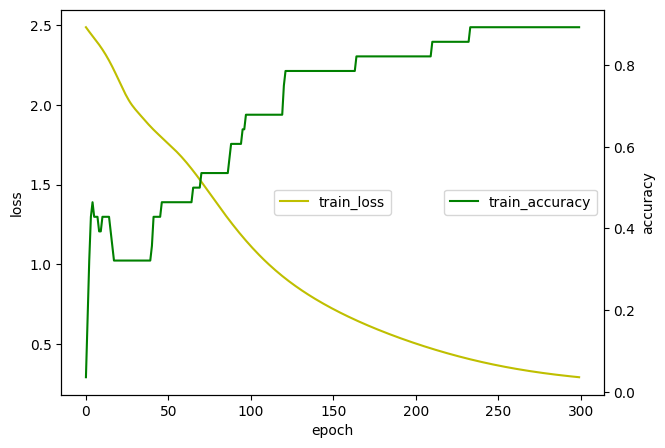

In [18]:
# 시각화
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [20]:
# 6. 모델 사용하기(경마장에 -> 있는)
encoded = t.texts_to_sequences(['경마장에'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data, verbose=0).argmax()
print('모델 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break

모델 예측 결과 : 3
예측한 단어 : 있는


In [21]:
encoded = t.texts_to_sequences(['겨울은'])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
input_data

array([[0, 0, 0, 0, 0]])

In [27]:
# 6. 모델 사용하기(사용자로부터 입력받은 문자 -> ?)
word = input('입력 단어는 ?')
encoded = t.texts_to_sequences([word])[0]
input_data = pad_sequences([encoded], maxlen=5, padding='pre')
result = model.predict(input_data, verbose=0).argmax()
print('모델 예측 결과 :', result)
for key, value in t.word_index.items():
    if value==result:
        print('예측한 단어 :', key)
        break

입력 단어는 ?가는 말이
모델 예측 결과 : 9
예측한 단어 : 고와야


# 2. 다음 문맥 예측해 보기

In [42]:
# "경마장에" 이후 단어 4개의 문맥을 만들어 줘
def sentence_generation(model, current_word, n):
    for i in range(1, n+1):
        print(f'{i}번째 current_word: ', current_word)
        encoded = t.texts_to_sequences([current_word])
        input_data = pad_sequences(encoded, maxlen=my_len-1, padding='pre')
        result = model.predict(input_data, verbose=0).argmax()
        for word, index in t.word_index.items():
            if result==index:
                print("{}번째 예측 {}: {}".format(i, result, word))
                current_word = current_word + ' ' + word
                break # inner for문 break
    print(f'{n}번째 current_word: ', current_word)

In [43]:
sentence_generation(model, "경마장에", 4)

1번째 current_word:  경마장에
1번째 예측 3: 있는
2번째 current_word:  경마장에 있는
2번째 예측 1: 말이
3번째 current_word:  경마장에 있는 말이
3번째 예측 4: 뛰고
4번째 current_word:  경마장에 있는 말이 뛰고
4번째 예측 5: 있다
4번째 current_word:  경마장에 있는 말이 뛰고 있다
